Audio Neural Style Transfer with Pytorch
============================
This is an implementation of neural style transfer using the alogrithm developed in
[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.

However instead of learning style from images we use the spectrogram in place to carry out the procedure on audio.

General implementation is based off the [Pytorch tutorial on Neural Transfer](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html) by Alexis Jacq. Also inspired by [Audio texture synthesis](https://github.com/DmitryUlyanov/neural-style-audio-torch) by Dmitry Ulyanov.

In [1]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import math

In [2]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = True


In [3]:
# set filenames
STYLE_FILENAME = "inputs/gettysburg.mp3" #input filename
outdir = 'outputs/test' #output dir
runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

# architecture
# either use a custom 1D convolutional random network, or use a pretrained VGG19 
use01scale = True #set to true if want to scale img to [0,1] prior to training. Recommended if using VGG19
useVGG = False #set True or False

"""if using useVGG==True set whichChannel==2d below, else change settings"""
whichChannel = "freq" #2d=2d conv, 1d options:freq=freq bins as channels, time= time bins as channels 
N_FILTERS = 2048 #no. of filters in 1st conv layer
hor_filter = 11 #width of conv filter, for 2d also the height of (square) kernel


#OUTPUT_FILENAME = ['outputs/getty_conv1_relu1.wav']'outputs/getty_conv1_relu1.wav'

In [4]:
display(Audio(STYLE_FILENAME))

In [5]:
# convert audio samples to spectrograms using librosa
N_FFT = 2048
K_HOP = 1024

def read_audio_spectum(filename):
    x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    R = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT,  center=False))
    return R, fs

def log_scale(img):
    img = np.log1p(img)
    return img

def inv_log(img):
    img = np.exp(img) - 1.
    return img

def findMinMax(img):
    return int(math.floor(np.amin(img))),int(math.ceil(np.amax(img)))

def img_scale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [datasetMin,datasetMax] -> [scaleMin,scaleMax]"""    
    shift = (scaleMax-scaleMin) / (datasetMax-datasetMin)
    scaled_values = shift * (img-datasetMin) + scaleMin
    print("Using [{0},{1}] -> [{2},{3}] for scale conversion".format(datasetMin,datasetMax,scaleMin,scaleMax))
    return scaled_values

def img_invscale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [scaleMin,scaleMax] -> [datasetMin,datasetMax]"""
    shift = (datasetMax-datasetMin) / (scaleMax-scaleMin)
    scaled_values = shift * (img-scaleMin) + datasetMin
    print("Using [{0},{1}] -> [{2},{3}] for scale conversion".format(scaleMin,scaleMax,datasetMin,datasetMax))
    return scaled_values
    

# use below functions to use librosa db scale, normalized to [0,1]
# note that this scaling does not work well for style transfer
def db_scale(img,scale=80):
    img = librosa.amplitude_to_db(img)
    shift = float(np.amax(img))
    img = img - shift #put max at 0
    img = img/scale #scale from [-80,0] to [-1,0]
    img = img + 1. #shift to [0,1]
    img = np.maximum(img, 0) #clip anything below 0
    return img, shift

def inv_db(img,shift,scale=80):
    img = img - 1. #shift from [0,1] to [-1,0]
    img = img * scale #[-1,0] -> [-80,0]
    img = img + shift
    img = librosa.db_to_amplitude(img)    
    return img


9.6456e-08 92.9556
Using [0,5] -> [0,1] for scale conversion


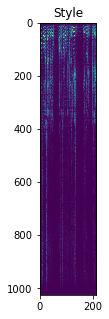

Min = 1.92912e-08 Max = 0.908564
(1025, 214)
torch.Size([1, 1025, 1, 214])


In [6]:
R, fs = read_audio_spectum(STYLE_FILENAME)
print(np.amin(R),np.amax(R))
a_style = log_scale(R)
if use01scale == True:
    a_min,a_max = findMinMax(a_style)
    a_style = img_scale(a_style,a_min,a_max,0,1)


plt.ion()
plt.figure(figsize=(10, 5))
plt.title('Style')
plt.imshow(a_style)
plt.show()
print("Min =",np.amin(a_style),"Max =",np.amax(a_style))
print(a_style.shape)

N_SAMPLES = a_style.shape[1] #time bins
N_FREQ = a_style.shape[0] #freq bins

a_style = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]
if whichChannel == "2d":
    a_style = torch.from_numpy(a_style) #pytorch:[batch,channels(1),height(freq),width(samples)]
elif whichChannel == "freq":
    a_style = torch.from_numpy(a_style).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]
elif whichChannel == "time":
    a_style = torch.from_numpy(a_style).permute(0,3,1,2) #pytorch:[batch,channels(samples),height(1),width(freq)]

style_img = Variable(a_style).type(dtype) #convert to pytorch variable
print(style_img.data.shape) #check shape is correct

(1025, 214)
Min = 1.92912e-08 Max = 0.908564


array([[  1.51870921e-02,   4.98674391e-03,   2.56976392e-02, ...,
          1.81828607e-02,   2.95387954e-03,   2.54532453e-02],
       [  1.80642083e-02,   1.21286996e-02,   3.70693691e-02, ...,
          1.87028050e-02,   1.04494987e-03,   3.90248112e-02],
       [  1.75411645e-02,   2.50634085e-02,   2.85844002e-02, ...,
          1.35583850e-02,   1.92967206e-02,   4.55022305e-02],
       ..., 
       [  1.14908680e-05,   9.30744864e-05,   1.65578720e-04, ...,
          2.05933120e-05,   2.29146008e-05,   6.24050654e-06],
       [  6.87693773e-06,   9.01856183e-05,   1.19080207e-04, ...,
          2.82873225e-05,   1.07812839e-05,   7.57432963e-06],
       [  1.53774124e-06,   8.18705375e-05,   3.77976503e-05, ...,
          1.76121193e-05,   7.82840198e-06,   5.34916899e-06]], dtype=float32)

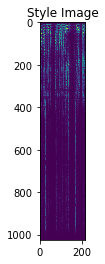

In [7]:
def imshow(tensor, channels=1, title=None):
    """ transforms pytorch tensor to numpy array and plots it out """
    
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    if whichChannel == "2d":
        image = image
    if whichChannel == "freq":
        image = image.permute(0,2,1,3).contiguous() # get the dimensions in proper order
    elif whichChannel == "time":
        image = image.permute(0,2,3,1).contiguous() # get the dimensions in proper order
    image = image.view(N_FREQ,N_SAMPLES)  # remove the fake batch dimension
    
    image = image.numpy() #convert pytorch tensor to numpy array
    print(image.shape) #check shape
    print("Min =",np.amin(image),"Max =",np.amax(image))
    
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image #return numpy array


plt.figure()
imshow(style_img.data, title='Style Image')

#plt.figure()
#imshow(content_img.data, title='Content Image')

Content loss
~~~~~~~~~~~~

The content loss is a function that takes as input the feature maps
$F_{XL}$ at a layer $L$ in a network fed by $X$ and
return the weigthed content distance $w_{CL}.D_C^L(X,C)$ between
this image and the content image. Hence, the weight $w_{CL}$ and
the target content $F_{CL}$ are parameters of the function. We
implement this function as a torch module with a constructor that takes
these parameters as input. The distance $\|F_{XL} - F_{YL}\|^2$ is
the Mean Square Error between the two sets of feature maps, that can be
computed using a criterion ``nn.MSELoss`` stated as a third parameter.

We will add our content losses at each desired layer as additive modules
of the neural network. That way, each time we will feed the network with
an input image $X$, all the content losses will be computed at the
desired layers and, thanks to autograd, all the gradients will be
computed. For that, we just need to make the ``forward`` method of our
module returning the input: the module becomes a ''transparent layer''
of the neural network. The computed loss is saved as a parameter of the
module.

Finally, we define a fake ``backward`` method, that just call the
backward method of ``nn.MSELoss`` in order to reconstruct the gradient.
This method returns the computed loss: this will be useful when running
the gradient descent in order to display the evolution of style and
content losses.




In [8]:
class ContentLoss(nn.Module):
    """Since doing texture only we ignore this for now"""

    def __init__(self, target, weight): #weight here is the epsilon tuning (how much content vs style)
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

.. Note::
   **Important detail**: this module, although it is named ``ContentLoss``,
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss, you have to create a PyTorch autograd Function
   and to recompute/implement the gradient by the hand in the ``backward``
   method.

Style loss
~~~~~~~~~~

For the style loss, we need first to define a module that compute the
gram produce $G_{XL}$ given the feature maps $F_{XL}$ of the
neural network fed by $X$, at layer $L$. Let
$\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a
$K$\ x\ $N$ matrix, where $K$ is the number of feature
maps at layer $L$ and $N$ the lenght of any vectorized
feature map $F_{XL}^k$. The $k^{th}$ line of
$\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that
$\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it
becomes easy to implement our module:




In [9]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(=1)
                                  #b=number of feature maps
                                  #(c,d)=dimensions of a feat. map (N=c*d) -> for 1D conv c=1

        #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        features = input.view(b, a * c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * c * d)

The longer is the feature maps dimension $N$, the bigger are the
values of the gram matrix. Therefore, if we don't normalize by $N$,
the loss computed at the first layers (before pooling layers) will have
much more importance during the gradient descent. We dont want that,
since the most interesting style features are in the deepest layers!

Then, the style loss module is implemented exactly the same way than the
content loss module, but we have to add the ``gramMatrix`` as a
parameter:




In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight): #weight here is the alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss(size_average=False)

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

Load the neural network
~~~~~~~~~~~~~~~~~~~~~~~

Now, we have to import a pre-trained neural network. As in the paper, we
are going to use a pretrained VGG network with 19 layers (VGG19).

PyTorch's implementation of VGG is a module divided in two child
``Sequential`` modules: ``features`` (containing convolution and pooling
layers) and ``classifier`` (containing fully connected layers). We are
just interested by ``features``:




A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU,
Maxpool2d, Conv2d, ReLU...) aligned in the right order of depth. As we
said in *Content loss* section, we wand to add our style and content
loss modules as additive 'transparent' layers in our network, at desired
depths. For that, we construct a new ``Sequential`` module, in wich we
are going to add modules from ``vgg19`` and our loss modules in the
right order:




In [11]:
import collections as c

# custom weights initialization
def weights_init(m):
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQ + N_FILTERS) * hor_filter))
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, std)

class style_net(nn.Module):
    """Here create the network you want to use by adding/removing layers in nn.Sequential"""
    def __init__(self):
        super(style_net, self).__init__()
        self.layers = nn.Sequential(c.OrderedDict([
                            ('conv1',nn.Conv2d(N_FREQ,N_FILTERS,kernel_size=(1,hor_filter),bias=False)),
                            ('relu1',nn.ReLU()),
                            #('max1', nn.MaxPool2d(kernel_size=(1,2))),
                            ('conv2',nn.Conv2d(N_FILTERS,N_FILTERS*2,kernel_size=(1,hor_filter),bias=False)),
                            ('relu2',nn.ReLU())]))
        
    def forward(self,input):
        out = self.layers(input)
        return out
    
if useVGG == True:
    cnn = models.vgg19(pretrained=True).features
    print(list(cnn))
else:
    cnn = style_net()
    cnn.apply(weights_init)
    for param in cnn.parameters():
        param.requires_grad = False
    print(list(cnn.layers))

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

[Conv2d(1025, 2048, kernel_size=(1, 11), stride=(1, 1), bias=False), ReLU (), Conv2d(2048, 4096, kernel_size=(1, 11), stride=(1, 1), bias=False), ReLU ()]


In [12]:
# Add the style/content loss 'layer' after the specified layer:
content_layers_default = [] #ignore for now
style_layers_default = ['relu_2'] #'relu_1'

#rebuild network with the layers we want
def get_style_model_and_losses(cnn, style_img, content_img=None,
                               style_weight=1, content_weight=0,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []
    
    """ if want to replace 1st layer in VGG19 to take in greyscale use below
    then start the loop with (cnn.layers)[1:]"""
    if useVGG == True:
        model = nn.Sequential(c.OrderedDict([ 
                ('conv_1',nn.Conv2d(1,64,kernel_size=(hor_filter,hor_filter),bias=False))]))
        layer_list = list(cnn)[1:]
    else:
        model = nn.Sequential()# the new Sequential module network
        layer_list = list(cnn.layers)
    
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    #here we rebuild the network adding the in content and style loss "layers"   
    i = 1  
    for layer in layer_list:
        if isinstance(layer, nn.Conv2d): #if layer in vgg19 belong to class nn.Conv2d
            name = "conv_" + str(i)
            model.add_module(name, layer) #add that layer to our sequential model
            
            if content_img != None:
                if name in content_layers: #at the right depth add the content loss "layer"
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers: #at the right depth add the content loss "layer"
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): #do the same for ReLUs
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if content_img != None:
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss) 
                
            i += 1

        if isinstance(layer, nn.MaxPool2d): #do the same for maxpool
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            #avgpool = nn.AvgPool2d(kernel_size=(1,2),
            #                stride=layer.stride, padding = layer.padding)
            #model.add_module(name, avgpool)  # *** can also replace certain layers if we want eg. maxpool -> avgpool


    #for param in model.parameters():
    #    param.requires_grad = False
    return model, style_losses, content_losses

.. Note::
   In the paper they recommend to change max pooling layers into
   average pooling. With AlexNet, that is a small network compared to VGG19
   used in the paper, we are not going to see any difference of quality in
   the result. However, you can use these lines instead if you want to do
   this substitution:

   ::

       # avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size,
       #                         stride=layer.stride, padding = layer.padding)
       # model.add_module(name,avgpool)



Input image
~~~~~~~~~~~

Again, in order to simplify the code, we take an image of the same
dimensions than content and style images. This image can be a white
noise, or it can also be a copy of the content-image.




In [13]:
#image to input in generative network
#input_img = content_img.clone()

# if you want to use a white noise instead uncomment the below line:
#input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

def in_img():
    """initialize (runs) number of unique random noise input images"""  
    input_imgs = []
    #rand_tensor = torch.randn(1,N_FREQ,1,N_SAMPLES)*1e-3
    i = 0
    while i < runs:
        if whichChannel == "2d":
            input_imgs.append(Variable(torch.randn(1,1,N_FREQ,N_SAMPLES)*1e-2+0.5).type(dtype))
        if whichChannel == "freq":
            input_imgs.append(Variable(torch.randn(1,N_FREQ,1,N_SAMPLES)*1e-2+0.5).type(dtype))
        elif whichChannel == "time":
            input_imgs.append(Variable(torch.randn(1,N_SAMPLES,1,N_FREQ)*1e-2+0.5).type(dtype))
        i +=1
    return input_imgs

input_imgs = in_img()

# add the original input image to the figure:
#plt.figure()
#imshow(input_img.data, title='Input Image')

Gradient descent
~~~~~~~~~~~~~~~~

As Leon Gatys, the author of the algorithm, suggested
`here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__,
we will use L-BFGS algorithm to run our gradient descent. Unlike
training a network, we want to train the input image in order to
minimise the content/style losses. We would like to simply create a
PyTorch  L-BFGS optimizer, passing our image as the variable to optimize.
But ``optim.LBFGS`` takes as first argument a list of PyTorch
``Variable`` that require gradient. Our input image is a ``Variable``
but is not a leaf of the tree that requires computation of gradients. In
order to show that this variable requires a gradient, a possibility is
to construct a ``Parameter`` object from the input image. Then, we just
give a list containing this ``Parameter`` to the optimizer's
constructor:




In [14]:
a = torch.rand(100,100)
print(torch.max(a),torch.min(a))

0.9998656511306763 0.00010420521721243858


In [15]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

def optbound_regularizer(img,upper,lower):
    """soft bound the optimization between [lower,upper] by regularization"""
    over = torch.max(img-upper,torch.zeros(img.size()).type(dtype))
    #print(over)
    under = torch.max(lower-img,torch.zeros(img.size()).type(dtype))
    #print(under)
    out = over + under
    #print(out)
    out = out.norm(2)
    #print(out)
    l2_reg = Variable(torch.cuda.FloatTensor([out]), requires_grad=True)
    
    return l2_reg

**Last step**: the loop of gradient descent. At each step, we must feed
the network with the updated input in order to compute the new losses,
we must run the ``backward`` methods of each loss to dynamically compute
their gradients and perform the step of gradient descent. The optimizer
requires as argument a "closure": a function that reevaluates the model
and returns the loss.

In [16]:
def run_style_transfer(cnn, style_img, input_img, content_img=None, num_steps=1000,
                       style_weight=1, content_weight=0, reg_weight=1e5):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    print(torch.max(input_param.data),torch.min(input_param.data))
    print(input_param.data.shape)
    
    print(model)
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            #if use01scale == True:
                #input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward() #call backward method to grab the loss
            #for cl in content_losses:
            #    content_score += cl.backward()
            bound_loss = optbound_regularizer(input_param.data,1,0)
            #bound_score = bound_loss.backward()
            #print(bound_score.data)
            #bound_score = bound_loss.backward()
            
            total_loss =  style_score + reg_weight*bound_loss  #+ content_score  

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f}'.format(
                    style_score.data[0]))
                print('Bound Loss : {:4f}'.format(
                    bound_loss.data[0]*reg_weight))
                #print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                #    style_score.data[0], content_score.data[0]))
                print('Total Loss : {:4f}'.format(
                    total_loss.data[0]))
            
            
            return total_loss   

        optimizer.step(closure)

    # a last correction...
    #if use01scale == True:
        #input_param.data.clamp_(0, 1)

    return input_param.data

Finally, run the algorithm



Building the style transfer model..
0.5497983694076538 0.4559767544269562
torch.Size([1, 1025, 1, 214])
Sequential (
  (conv_1): Conv2d(1025, 2048, kernel_size=(1, 11), stride=(1, 1), bias=False)
  (relu_1): ReLU ()
  (conv_2): Conv2d(2048, 4096, kernel_size=(1, 11), stride=(1, 1), bias=False)
  (relu_2): ReLU ()
  (style_loss_2): StyleLoss (
    (gram): GramMatrix (
    )
    (criterion): MSELoss (
    )
  )
)
Optimizing..


/home/huzaifah/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


run [50]:
Style Loss : 2.418353
Bound Loss : 3258047.103882
Total Loss : 3258049.500000
run [100]:
Style Loss : 1.151567
Bound Loss : 3283482.360840
Total Loss : 3283483.500000
run [150]:
Style Loss : 0.833095
Bound Loss : 3309305.191040
Total Loss : 3309306.000000
run [200]:
Style Loss : 0.681154
Bound Loss : 3329419.708252
Total Loss : 3329420.500000
run [250]:
Style Loss : 0.596529
Bound Loss : 3343383.026123
Total Loss : 3343383.500000
run [300]:
Style Loss : 0.536584
Bound Loss : 3357451.629639
Total Loss : 3357452.250000
run [350]:
Style Loss : 0.492973
Bound Loss : 3370508.575439
Total Loss : 3370509.000000
run [400]:
Style Loss : 0.459553
Bound Loss : 3383548.355103
Total Loss : 3383548.750000
run [450]:
Style Loss : 0.434030
Bound Loss : 3393589.019775
Total Loss : 3393589.500000
run [500]:
Style Loss : 0.412973
Bound Loss : 3401865.386963
Total Loss : 3401866.000000
run [550]:
Style Loss : 0.395166
Bound Loss : 3411125.564575
Total Loss : 3411126.000000
run [600]:
Style Loss 

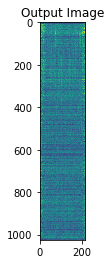

In [17]:
outputs = []
i = 0
while i < runs:
    
    output = run_style_transfer(cnn, style_img, input_imgs[i])

    plt.figure()
    out = imshow(output, title='Output Image')
    outputs.append(out)
    i += 1

# sphinx_gallery_thumbnail_number = 4
plt.show()

In [18]:
#out_spec = inv_scale(out,shf)
for j in range(len(outputs)):
    print(np.amin(outputs[j]),np.amax(outputs[j])) # check values make sense

if use01scale == True:
    out_spec = [inv_log(img_invscale(x,a_min,a_max,0,1)) for x in outputs]
else:
    out_spec = [inv_log(x) for x in outputs]

for j in range(len(out_spec)):
    print(np.amin(out_spec[j]),np.amax(out_spec[j])) # check values make sense

-0.765039 1.25059
Using [0,1] -> [0,5] for scale conversion
-0.978186 518.539


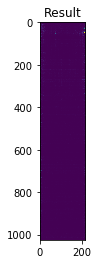

In [19]:
# Griffin & Lim algo for phase reconstruction

for index,value in enumerate(out_spec):
    p = 2 * np.pi * np.random.random_sample(value.shape) - np.pi #start with some phase
    for i in range(500):
        S = value * np.exp(1j*p) #use magnitude a given by spectrogram and some random phase
        x = librosa.istft(S,hop_length=K_HOP, win_length=N_FFT, center=False) #do the inverse transform
        p = np.angle(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT, center=False)) #use this new phase value

    try:
        os.stat(outdir) # test for existence
    except:
        os.mkdir(outdir) # create if necessary    
    librosa.output.write_wav(outdir + '/' + str(index) + '.wav', x, fs)
    plt.figure()
    plt.title('Result')
    plt.imshow(value)
    plt.show()

plt.ioff()

In [20]:
#print(OUTPUT_FILENAME)
#display(Audio(OUTPUT_FILENAME))